In [1]:
import tensorflow as tf
import numpy as np
import importlib.util
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def load_module(path):
    spec = importlib.util.spec_from_file_location("module.name", path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

def load_arch(arch_path):
    arch = load_module(arch_path)
    nn = arch.CNN()

    g = tf.Graph()
    with g.as_default():
        nn.create_architecture()
    return g, nn

In [3]:
graph, nn = load_arch("arch_invariant_a.py")

In [4]:
sess = tf.Session(graph=graph)

In [5]:
sess.run(tf.variables_initializer(graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)))

<IPython.core.display.Javascript object>


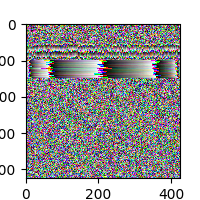

In [6]:
x = np.random.normal(size=(424, 424, 3))
x[50:100, :, :]  = np.sort(x[50:100, :, :], 0)
x[100:150, :, :] = np.sort(x[100:150, :, :], 1)
x[150:200, :, :] = np.sort(x[150:200, :, :], 2)
plt.figure(figsize=(2,2))
plt.imshow(x)

In [7]:
def dihedral(x, i):
    x = x.copy()
    if i & 4:
        x = np.transpose(x, (1, 0, 2))  # tau[4]
    if i & 1:
        x = x[:, ::-1, :]  # tau[1]
    if i & 2:
        x = x[::-1, :, :]  # tau[2]
    return x

In [8]:
xs = np.array([dihedral(x, i) for i in range(8)])

In [9]:
ps = sess.run(nn.tfp, feed_dict={nn.tfx: xs})
print(np.transpose(ps))

[[  8.96935701e-01   8.96934807e-01   8.96936178e-01   8.96935403e-01
    8.96934450e-01   8.96933019e-01   8.96935582e-01   8.96935403e-01]
 [  9.67576802e-02   9.67585295e-02   9.67572257e-02   9.67578962e-02
    9.67588648e-02   9.67601836e-02   9.67576951e-02   9.67578962e-02]
 [  6.30669063e-03   6.30667806e-03   6.30668458e-03   6.30675443e-03
    6.30672369e-03   6.30680053e-03   6.30674046e-03   6.30674558e-03]
 [  8.13144520e-02   8.13154504e-02   8.13140124e-02   8.13143402e-02
    8.13153312e-02   8.13164115e-02   8.13142508e-02   8.13144669e-02]
 [  1.54432300e-02   1.54430773e-02   1.54432133e-02   1.54435551e-02
    1.54435374e-02   1.54437702e-02   1.54434387e-02   1.54434284e-02]
 [  6.86781108e-03   6.86774310e-03   6.86780689e-03   6.86787907e-03
    6.86797174e-03   6.86802529e-03   6.86788885e-03   6.86791306e-03]
 [  8.57541803e-03   8.57533421e-03   8.57540593e-03   8.57567601e-03
    8.57556518e-03   8.57574586e-03   8.57554935e-03   8.57551675e-03]
 [  8.0468161

In [10]:
test = sess.run(nn.test, feed_dict={nn.tfx: xs})
test = np.reshape(test, (8, 8, -1))

<IPython.core.display.Javascript object>


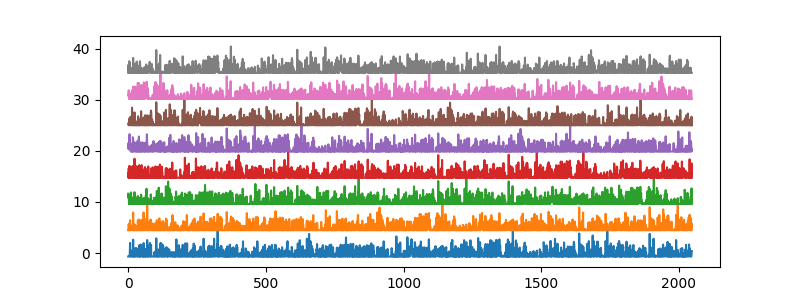

In [11]:
step = test[0].max() - test[0].min()
plt.figure(figsize=(8,3))
for i in range(8):
    plt.plot(test[i].flatten() + step * i)

<IPython.core.display.Javascript object>


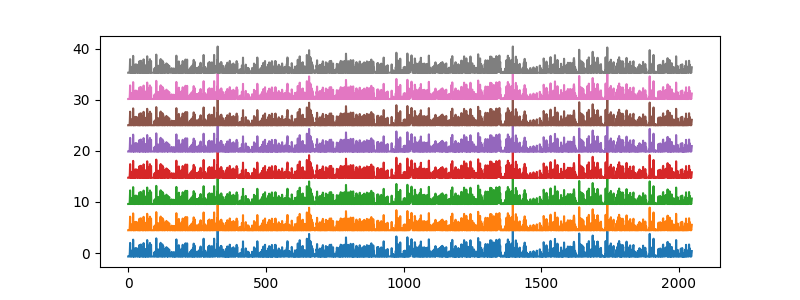

In [12]:
mt = np.array([ [0, 1, 2, 3, 4, 5, 6, 7], [1, 0, 3, 2, 5, 4, 7, 6],
                [2, 3, 0, 1, 6, 7, 4, 5], [3, 2, 1, 0, 7, 6, 5, 4],
                [4, 6, 5, 7, 0, 2, 1, 3], [5, 7, 4, 6, 1, 3, 0, 2],
                [6, 4, 7, 5, 2, 0, 3, 1], [7, 5, 6, 4, 3, 1, 2, 0]])
# tau[mt[a,b]] = tau[a] o tau[b]

iv = np.array([0, 1, 2, 3, 4, 6, 5, 7])
# tau[iv[a]] is the inverse of tau[a]

plt.figure(figsize=(8,3))
for i in range(8):
    plt.plot(test[i][mt[i]].flatten() + step * i)